# Klasyfikacja raka mózgu - Hubert Jaremko

## Sieć konwolucyjna

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import walk
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

### Ustawienia

In [2]:
cancer_type = {0 : 'Oponiak', 1 : 'Glejak', 2 : 'Guz przysadki'}

In [3]:
# image_size = (512, 512)
# image_size = (224, 224)
# image_size = (128, 128)
image_size = (64, 64)
batch_size = 32

train_dir = "data/train"
val_dir = "data/val"

## Funkcje pomocnicze

In [4]:
def plot_metrics(history):
    metrics = ['loss', 'categorical_accuracy', 'precision', 'recall']
    plt.figure(figsize=(12, 7))
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.ylim([0, 1])
        plt.legend()

In [5]:
def plot_confusion_matrix(y_pred, y_true):
    plt.figure(figsize=(6, 5))
    cm = metrics.confusion_matrix(y_pred=predicted_classes, y_true=true_classes)
    sn.heatmap(cm, annot=True, fmt='g', cmap="RdPu")
    plt.show()

In [37]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target = ['Oponiak', 'Glejak', 'Guz przysadki']

def binarize_labels(y_test):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    return y_test

def multiclass_roc_auc_score(y_test, y_pred, c_ax, average="macro"):
    y_test = binarize_labels(y_test)
    
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = f'{c_label} (AUC:{auc(fpr, tpr):0.2f})')

    c_ax.plot(fpr, fpr, '--', color = '0.75', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

def plot_roc_curve(y_test, y_pred):
    fig, c_ax = plt.subplots(1, 1, figsize = (5, 3))

    print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred, c_ax))

    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()

## Wczytanie zbioru testowego i walidacyjnego

*Augmentacja danych* - losowe odbijanie w poziomie i pionie oraz zmiana jasności obrazu.

In [7]:
train_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2)
#     brightness_range=(1.0, 2.0)
)

train_data_generator = train_generator.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

train_steps_per_epoch = np.math.ceil(train_data_generator.samples / train_data_generator.batch_size)


Found 3678 images belonging to 3 classes.


In [8]:
test_generator = ImageDataGenerator()

test_data_generator = test_generator.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

Found 600 images belonging to 3 classes.


### Próbka zbioru testowego

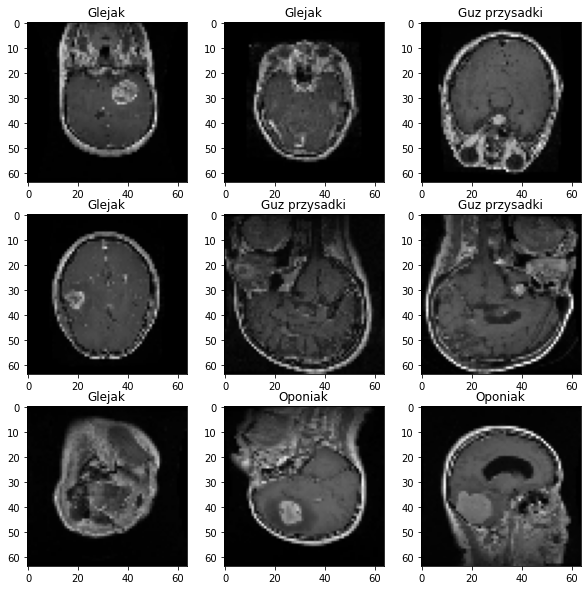

In [9]:
plt.figure(figsize=(10, 10))

b = next(train_data_generator)

images = b[0]
labels = b[1]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = images[i]
    label = labels[i]
    plt.imshow(image.astype("uint8"))
    label = cancer_type[np.argmax(label)]
    plt.title(label)

In [11]:
# train_ds = train_ds.prefetch(buffer_size=32)
# val_ds = val_ds.prefetch(buffer_size=32)

## Model
https://www.sciencedirect.com/science/article/pii/S2666827020300049

In [12]:
def make_lunet_model(input_shape):
    model = tf.keras.models.Sequential()

    model.add(layers.InputLayer(input_shape))
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation("elu"))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation("elu"))
    model.add(MaxPooling2D((3, 3)))
    model.add(Activation("elu"))

    model.add(Conv2D(64, (3, 3)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation("elu"))
    model.add(MaxPooling2D((3, 3)))
    model.add(Activation("elu"))

    model.add(UpSampling2D())
    model.add(Conv2D(6, (3, 3)))
    model.add(Conv2D(6, (3, 3)))
    model.add(Activation("elu"))

    model.add(UpSampling2D())
    model.add(Activation("elu"))
    model.add(Conv2D(64, (3, 3)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation("elu"))


    model.add(Flatten())
    model.add(Dense(128, activation="elu"))
    model.add(Dense(128, activation="elu"))
    model.add(Dense(3, activation="softmax"))
    return model

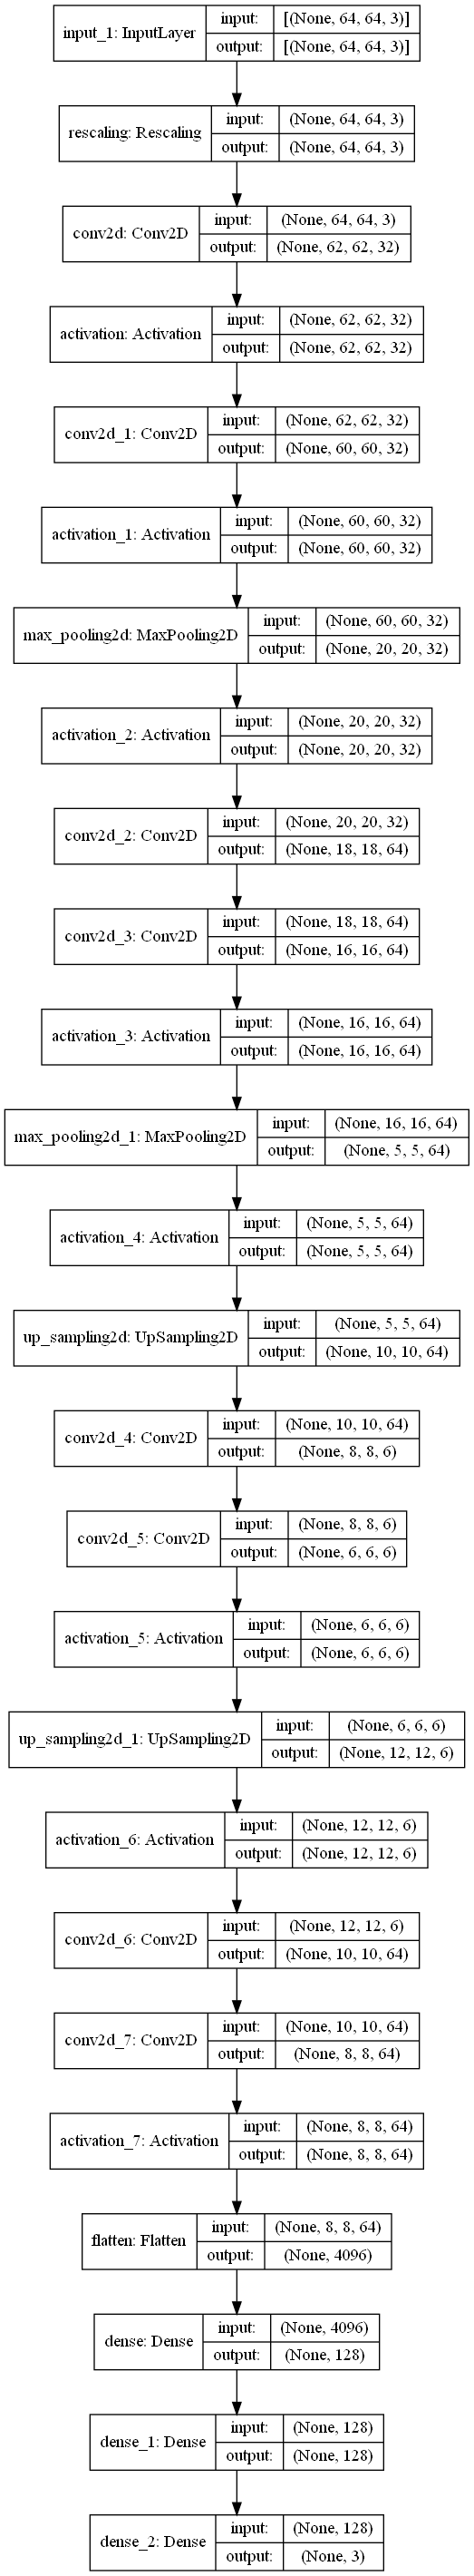

In [13]:
model = make_lunet_model(input_shape=image_size + (3,))
keras.utils.plot_model(model, show_shapes=True)
# model.summary()

In [14]:
epochs = 32

history = History()

callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1),
]

model.compile(
#     optimizer=keras.optimizers.Adam(0.00001),
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=[
        "categorical_accuracy",
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
    ],
)

history = model.fit(
    train_data_generator,
    steps_per_epoch=train_steps_per_epoch,

    validation_data=test_data_generator,
    validation_steps=test_steps_per_epoch,

    epochs=epochs, 
    callbacks=callbacks, 
)

Epoch 1/32
115/115 [==============================] - 52s 432ms/step - loss: 0.8288 - categorical_accuracy: 0.5756 - precision: 0.6106 - recall: 0.4682 - auc: 0.7947 - val_loss: 0.6848 - val_categorical_accuracy: 0.6633 - val_precision: 0.6820 - val_recall: 0.6183 - val_auc: 0.8628
Epoch 2/32
115/115 [==============================] - 48s 418ms/step - loss: 0.5656 - categorical_accuracy: 0.7368 - precision: 0.7538 - recall: 0.7077 - auc: 0.9068 - val_loss: 0.5034 - val_categorical_accuracy: 0.7717 - val_precision: 0.7840 - val_recall: 0.7500 - val_auc: 0.9275
Epoch 3/32
115/115 [==============================] - 50s 432ms/step - loss: 0.4175 - categorical_accuracy: 0.8260 - precision: 0.8338 - recall: 0.8187 - auc: 0.9508 - val_loss: 0.5273 - val_categorical_accuracy: 0.7733 - val_precision: 0.7808 - val_recall: 0.7717 - val_auc: 0.9311
Epoch 4/32
115/115 [==============================] - 52s 448ms/step - loss: 0.3627 - categorical_accuracy: 0.8524 - precision: 0.8562 - recall: 0.8464

Epoch 00029: early stopping


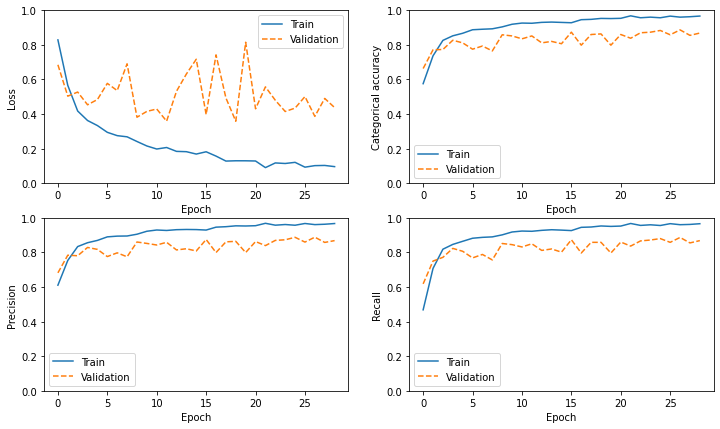

In [15]:
plot_metrics(history)

In [16]:
model.evaluate(test_data_generator)

19/19 [==============================] - 3s 152ms/step - loss: 0.4375 - categorical_accuracy: 0.8683 - precision: 0.8683 - recall: 0.8683 - auc: 0.9628


[0.4375063478946686,
 0.8683333396911621,
 0.8683333396911621,
 0.8683333396911621,
 0.9627839922904968]

In [34]:
predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

In [18]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

In [22]:
import sklearn.metrics
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           1       0.84      0.80      0.82       200
           2       0.86      0.89      0.87       200
           3       0.91      0.92      0.92       200

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600



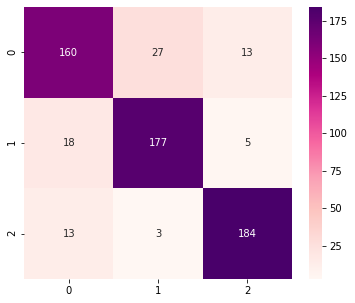

In [23]:
plot_confusion_matrix(predicted_classes, true_classes)

ROC AUC score: 0.9691875


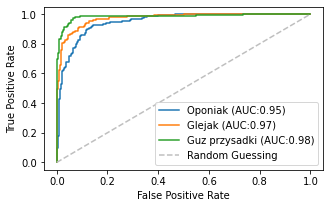

In [36]:
plot_roc_curve(true_classes, predictions)

In [20]:
def print_proba(score, i):
    print(
    f"{cancer_type[i]} : {score[i] * 100:0.2f}%"
)

In [33]:
img = keras.preprocessing.image.load_img(
    "data/val/3/13.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# print(img_array.shape)

p = model.predict(img_array)
score = p[0]
# print(score)
print_proba(score, 0)
print_proba(score, 1)
print_proba(score, 2)

Oponiak : 0.00%
Glejak : 0.00%
Guz przysadki : 100.00%
